In [1]:
# import library
#import obspy
#from obspy.clients.fdsn import Client
#from obspy import UTCDateTime
#from pyproj import CRS, Transformer
import pandas as pd
import numpy as np
from collections import Counter
#from tqdm import tqdm
import matplotlib.pyplot as plt
#import seaborn as sns
#import torch
import os
import matplotlib.dates as mdates
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
#from gamma.utils import association, estimate_eps
#from pyproj import Proj

In [2]:
stations = pd.read_csv("D:/SERD/01_meq/asosiasi/region/rantau_dedap/serd_stations.csv")

reloc_cat = pd.read_excel("D:/SERD/01_meq/file_csv/file_db_format/01_novdes2024/novdec2024_db_reloc_ct.xlsx")
init_cat = pd.read_excel("D:/SERD/01_meq/file_csv/file_db_format/01_novdes2024/novdec2024_nll_initcat.xlsx")
pick_df = pd.read_excel("D:/SERD/01_meq/file_csv/file_db_format/01_novdes2024/novdec2024_pick_cat.xlsx")
wadati_df = pd.read_excel("D:/SERD/01_meq/file_csv/file_db_format/01_novdes2024/novdec2024_wadati.xlsx")

if 'Unnamed: 0' in pick_df.columns:
    pick_df = pick_df.drop(columns=['Unnamed: 0'])
    wadati_df = wadati_df.drop(columns=['Unnamed: 0'])
    
pick_df.head(2)

,Event ID,Station,Year,Month,Day,Hour,Minutes_P,P_Arr_Sec,P_Polarity,P_Onset,Minutes_S,S_Arr_Sec,S_Polarity,S_Onset,Ts_Tp,Minutes_T0,T0_Sec,P Travel,S Travel,VpVs
0,2719,RD05,2024,11,1,14,56,40.525,+,E,56,41.01,?,E,0.485,56,39.832471,0.692529,1.177529,1.663795
1,2719,RD06,2024,11,1,14,56,40.515,-,E,56,40.95,?,E,0.435,56,39.832471,0.682529,1.117529,1.663795


In [3]:
init_cat.head(2)

,ID,Lat,Lon,UTM_X,UTM_Y,Depth,Elev,Year,Month,Day,Hour,Minute,T0,RMS_error,N_Phases,GAP,PDF_errXX(m),PDF_errYY(m),PDF_errZZ(m)
0,2719,-4.208389,103.373781,319503.024,9534650.202,-1.935,1.935,2024,11,1,14,56,39.857167,0.014263,8,285.255,380.400557,297.925716,204.050736
1,2720,-4.212558,103.406188,323101.815,9534196.573,902.827,-902.827,2024,11,2,1,29,4.347138,0.002644,6,213.445,1035.369692,689.279501,654.474797


In [4]:
reloc_cat.head(2)

,ID,Lat,Lon,UTM X (m),UTM Y (m),Depth (m),Elev (m),Year,Month,Day,Hour,Minute,OT(sec),RMS error,Remarks,Ml Magnitude,Mw Magnitude
0,2719,-4.206806,103.371216,319217.923617,9.534825e+06,-88.0,88.0,2024,11,1,14,56,39.89,0.019,Reloc,NaN,NaN
1,2720,-4.209280,103.413550,323918.429206,9.534561e+06,663.0,-663.0,2024,11,2,1,29,4.33,0.009,Reloc,NaN,NaN


In [5]:
stations.head(2)

,id,longitude,latitude,elevation_m,utmx,utmy
0,RD01,103.408419,-4.192293,1504,323344.9658,9536437.964
1,RD02,103.401842,-4.210773,1753,322618.9510,9534392.981


In [6]:
wadati_df.head(2)

,Event ID,Station,Year,Month,Day,Hour,Minutes_P,P_Arr_Sec,P_Polarity,P_Onset,...,S_Arr_Sec,S_Polarity,S_Onset,Ts-Tp,Minutes_T0,T0_Sec,P Travel,S Travel,VpVs,Tp-T0
0,1,RD05,2024,11,1,14,56,40.525,+,E,...,41.01,?,E,0.485,56,39.832471,0.692529,1.177529,1.663795,0.692529
1,1,RD06,2024,11,1,14,56,40.515,-,E,...,40.95,?,E,0.435,56,39.832471,0.682529,1.117529,1.663795,0.682529


# Wadati Diagram

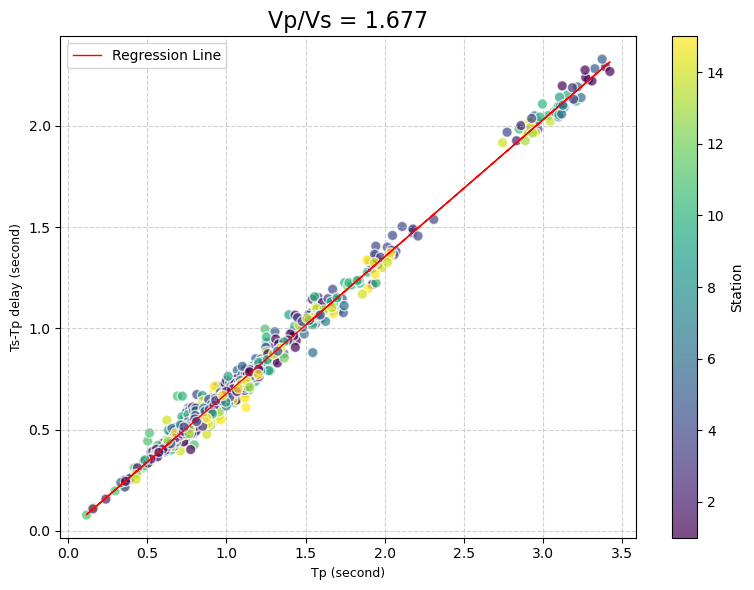

In [7]:
wadati_df['Station_encoded'] = wadati_df['Station'].str.extract(r'RD(\d+)')[0].astype(int)

# Perform linear regression
x = wadati_df['Tp-T0']
y = wadati_df['Ts-Tp']
slope, intercept = np.polyfit(x, y, 1)
regression_line = slope * x + intercept
xideal = [0, max(x)]
yideal = [intercept, max(x) * 0.73 + intercept]

# Create a scatter plot with matplotlib
plt.figure(figsize=(8, 6))
scatter = plt.scatter(x, y, c=wadati_df['Station_encoded'], cmap='viridis', alpha=0.7, edgecolors='w', s=55)
#plt.plot(xideal, yideal, color='k', linewidth=2, linestyle='--', label='Ideal Line', alpha=1)
plt.plot(x, regression_line, color='red', linewidth=1, linestyle='-', label='Regression Line')

# Add colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('Station')

# Add text annotation
#plt.text(min(x) + 10, max(regression_line) - 25, f'Vp/Vs = {1 + slope:.3f}', fontsize=12, ha='left', va='bottom')

# Set plot title and labels
plt.title(f'Vp/Vs = {1 + slope:.3f}', fontsize=16)
plt.xlabel('Tp (second)', fontsize=9)
plt.ylabel('Ts-Tp delay (second)', fontsize=9)

# Add a legend
plt.legend(loc='upper left', fontsize=10, frameon=True)

# Display the plot
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.savefig("D:/SERD/laporan/2025 02/wadati_novdes2024.png",dpi=500)
plt.show()

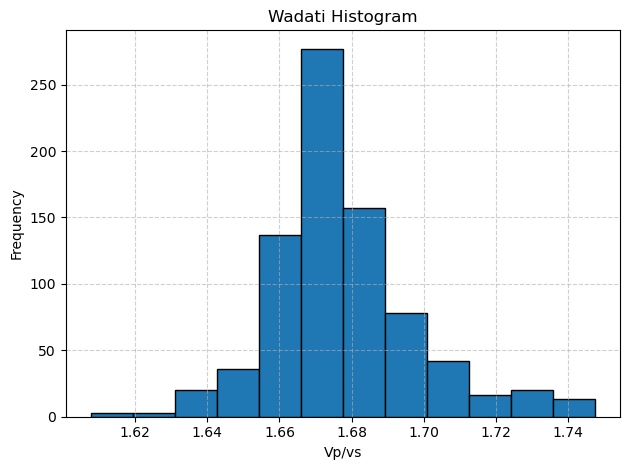

In [8]:
plt.hist(wadati_df['VpVs'], bins=12, edgecolor='k')
plt.title("Wadati Histogram")
plt.ylabel("Frequency")
plt.xlabel("Vp/vs")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
#plt.savefig("D:/SERD/laporan/2025 02/gambar/wadatihistogram_novdes2024.png",dpi=500)
plt.show()

# Event distribution by time

In [9]:
init_cat['origin_time'] = pd.to_datetime(
    init_cat['Year'].astype(str) + '-' +
    init_cat['Month'].astype(str).str.zfill(2) + '-' +
    init_cat['Day'].astype(str).str.zfill(2) + ' ' +
    init_cat['Hour'].astype(str).str.zfill(2) + ':' +
    init_cat['Minute'].astype(str).str.zfill(2) + ':' +
    init_cat['T0'].astype(int).astype(str), 
    errors='coerce', format='%Y-%m-%d %H:%M:%S'
)

reloc_cat['origin_time'] = pd.to_datetime(
    reloc_cat['Year'].astype(str) + '-' +
    reloc_cat['Month'].astype(str).str.zfill(2) + '-' +
    reloc_cat['Day'].astype(str).str.zfill(2) + ' ' +
    reloc_cat['Hour'].astype(str).str.zfill(2) + ':' +
    reloc_cat['Minute'].astype(str).str.zfill(2) + ':' +
    reloc_cat['OT(sec)'].astype(int).astype(str), 
    errors='coerce', format='%Y-%m-%d %H:%M:%S'
)

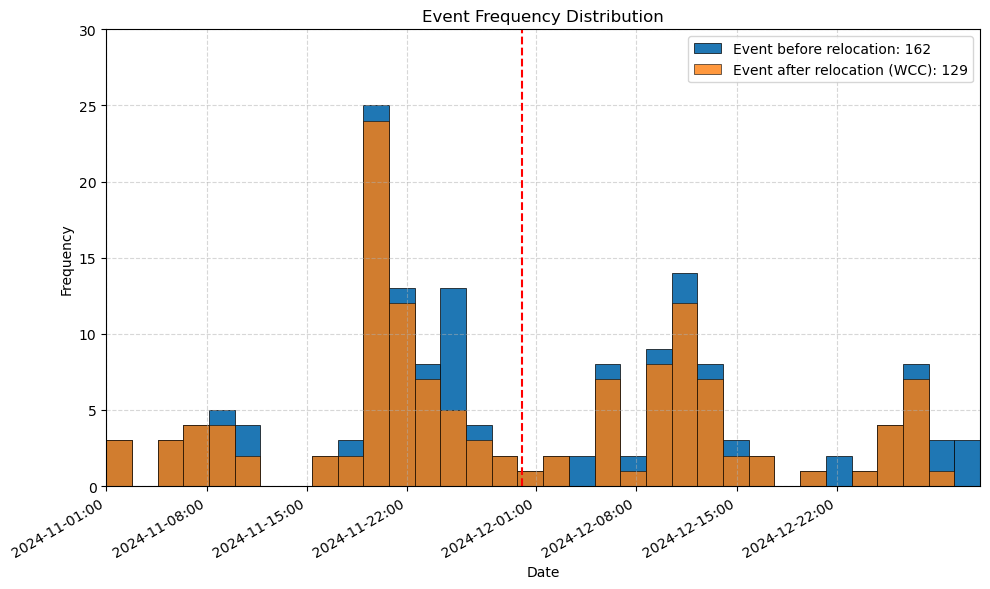

In [10]:
plt.figure(figsize=(10, 6))

starttime = '2024-11-01 00:00:00' #reloc_cat["time"].min()
endtime = '2024-12-31 23:59:59' #reloc_cat["time"].max()

# Histogram sebelum relokasi
plt.hist(
    init_cat["origin_time"],
    range=(starttime, endtime),
    bins=34,
    edgecolor="k",
    alpha=1,  # Transparansi
    linewidth=0.5,
    label=f"Event before relocation: {len(init_cat['origin_time'])}",
)

# Histogram setelah relokasi
plt.hist(
    reloc_cat["origin_time"],
    range=(starttime, endtime),
    bins=34,
    edgecolor="k",
    alpha=0.8,  # Transparansi
    linewidth=0.5,
    label=f"Event after relocation (WCC): {len(reloc_cat['origin_time'])}",
)
plt.axvline(pd.to_datetime('2024-11-30 00:00:00'), color='r', linestyle='dashed')

plt.ylabel("Frequency")
plt.ylim(0, 30)
plt.xlabel("Date")
plt.gca().autoscale(enable=True, axis='x', tight=True)

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d:%H'))
plt.gcf().autofmt_xdate()

plt.legend()
plt.title("Event Frequency Distribution")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig("D:/SERD/laporan/2025 02/gambar/event_distribution2.png", dpi=500)
plt.show()

# Num Phase per stations

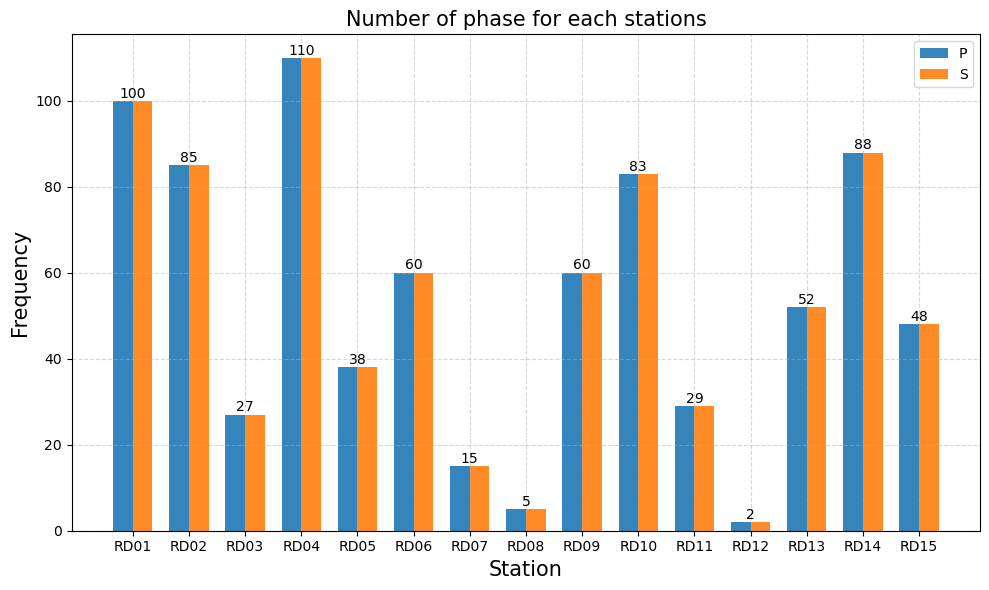

In [11]:
# Menghitung jumlah stasiun unik
station_counts = pick_df['Station'].value_counts()

# Jumlah P dan S adalah sama, jadi kita gunakan jumlah stasiun untuk P dan S
p_counts = station_counts
s_counts = station_counts

# Urutkan berdasarkan nama stasiun
p_counts = p_counts.sort_index()
s_counts = s_counts.sort_index()

# Plotting histogram
stations = p_counts.index
x = np.arange(len(stations))
width = 0.35  # Lebar bar

fig, ax = plt.subplots(figsize=(10, 6))

# Plot untuk P dan S
bars_p = ax.bar(x - width/2, p_counts, width, label='P', alpha=0.9)
bars_s = ax.bar(x + width/2, s_counts, width, label='S', alpha=0.9)

# Menambahkan label dan title
ax.set_xlabel('Station', size=15)
ax.set_ylabel('Frequency', size=15)
ax.set_title('Number of phase for each stations', size=15)
ax.set_xticks(x)
ax.set_xticklabels(stations)
ax.legend()

# Menampilkan angka di atas bar plot
for bar in bars_p:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width(), yval + 0.1, int(yval), ha='center', va='bottom')

# for bar in bars_s:
#     yval = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2, yval + 0.1, int(yval), ha='center', va='bottom')

# Menampilkan plot
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig("D:/SERD/laporan/2025 02/gambar/Number of picks for each station.png", dpi=500)
plt.show()

# Spatial Error for Initial hypocenter

In [12]:
init_cat.head(3)

,ID,Lat,Lon,UTM_X,UTM_Y,Depth,Elev,Year,Month,Day,Hour,Minute,T0,RMS_error,N_Phases,GAP,PDF_errXX(m),PDF_errYY(m),PDF_errZZ(m),origin_time
0,2719,-4.208389,103.373781,319503.024,9534650.202,-1.935,1.935,2024,11,1,14,56,39.857167,0.014263,8,285.255,380.400557,297.925716,204.050736,2024-11-01 14:56:39
1,2720,-4.212558,103.406188,323101.815,9534196.573,902.827,-902.827,2024,11,2,1,29,4.347138,0.002644,6,213.445,1035.369692,689.279501,654.474797,2024-11-02 01:29:04
2,2721,-4.210375,103.408644,323373.992,9534438.508,393.899,-393.899,2024,11,2,1,34,29.616276,0.040565,14,149.948,267.919363,452.867270,532.573745,2024-11-02 01:34:29


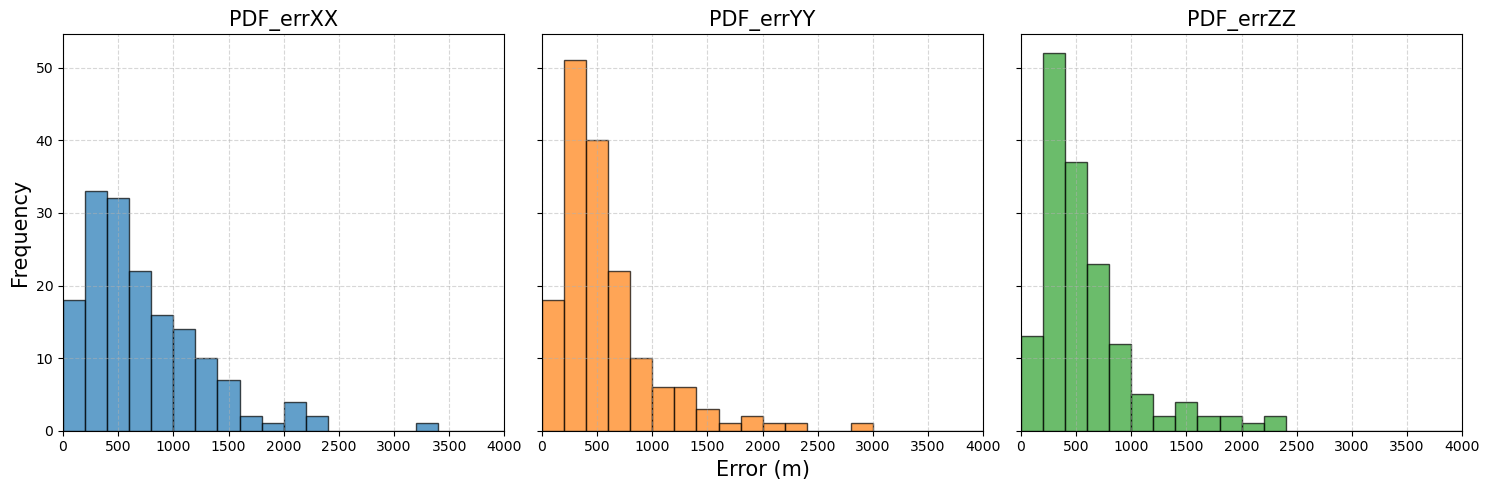

In [13]:
# Batas bin
bins = np.arange(0, 4200, 200)

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]  # biru, oranye, hijau

# Membuat subplot horizontal
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot histogram untuk PDF_errXX
ax1.hist(init_cat["PDF_errXX(m)"], bins=bins, edgecolor='black', alpha=0.7, color=colors[0])
ax1.set_title("PDF_errXX",fontsize=15)
ax1.set_xlim(0, 4000)
ax1.set_ylabel("Frequency",fontsize=15)
ax1.grid(True, linestyle="--", alpha=0.5)

# Plot histogram untuk PDF_errYY
ax2.hist(init_cat["PDF_errYY(m)"], bins=bins, edgecolor='black', alpha=0.7, color=colors[1])
ax2.set_title("PDF_errYY",fontsize=15)
ax2.set_xlim(0, 4000)
ax2.grid(True, linestyle="--", alpha=0.5)
ax2.set_xlabel("Error (m)",fontsize=15)

# Plot histogram untuk PDF_errZZ
ax3.hist(init_cat["PDF_errZZ(m)"], bins=bins, edgecolor='black', alpha=0.7, color=colors[2])
ax3.set_title("PDF_errZZ",fontsize=15)
ax3.set_xlim(0, 4000)
ax3.grid(True, linestyle="--", alpha=0.5)

plt.tight_layout()
#plt.savefig("D:/SERD/laporan/2025 02/gambar/spatial_error.png", dpi=500)
plt.show()

# Hypocenter RMS error

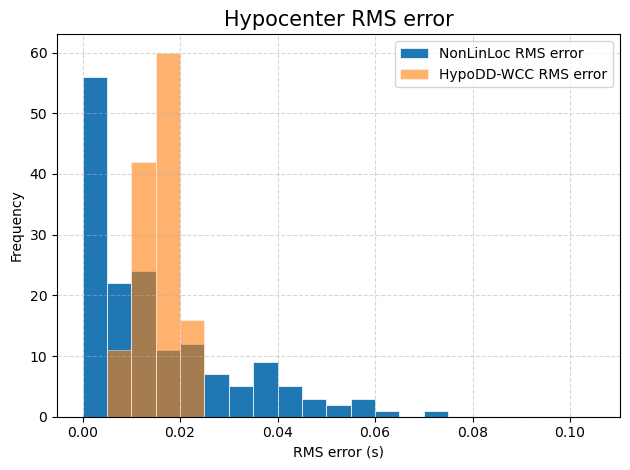

In [14]:
bins = np.arange(0, 0.11, 0.005)

plt.hist(init_cat['RMS_error'], linewidth=0.5, edgecolor='white',bins=bins, label="NonLinLoc RMS error")
plt.hist(reloc_cat['RMS error'], linewidth=0.5, edgecolor='white',bins=bins, alpha=0.6, label="HypoDD-WCC RMS error")

plt.title("Hypocenter RMS error", fontsize=15)
plt.ylabel("Frequency")
plt.xlabel("RMS error (s)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
#plt.savefig("D:/SERD/laporan/2025 02/gambar/hypocenter_rms.png", dpi=500)
plt.show()